In [1]:
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import collections
from functools import reduce
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import cplAE_MET.utils.analysis_helpers as proc_utils
from cplAE_MET.utils.load_config import load_config

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool'}


In [2]:
# set the config file name and the threshold for the pca explained variance
config_file = 'config_preproc.toml'
pca_th = 0.97

In [3]:
# Function to set the input and output path
def set_paths(config_file=None):
    paths, _ = load_config(config_file=config_file, verbose=False)

    paths['input'] = f'{str(paths["data_dir"])}'
    paths['specimen_ids'] = f'{paths["input"]}/{str(paths["specimen_ids_file"])}'
    paths['E_timeseries'] = f'{paths["input"]}/{str(paths["E_timeseries_file"])}'
    paths['ipfx_features'] = f'{paths["input"]}/{str(paths["ipfx_features_file"])}'
    paths['e_output'] = f'{paths["input"]}/{str(paths["e_output_file"])}'

    return paths

In [4]:
# Read the specimen ids of all the patchseq, ME, EM and fmost platforms
dir_pth = set_paths(config_file=config_file)
ids = pd.read_csv(dir_pth['specimen_ids'])
specimen_ids = ids['specimen_id'].tolist()
specimen_ids = [str(i) for i in specimen_ids]
print("...................................................")
print("There are", len(specimen_ids), "sample_ids in the locked dataset")

...................................................
There are 16703 sample_ids in the locked dataset


In [5]:
# Read the file with the timeseries
print("...................................................")
print("Loading E data time series")
hf = h5py.File(dir_pth['E_timeseries'], 'r')
h5_ids = [str(i) for i in np.array(hf.get("ids"))]
print("Number of cells in h5(time series file):", len(h5_ids))

...................................................
Loading E data time series
Number of cells in h5(time series file): 7838


In [6]:
# Some cleanups
repeated_ids = ([item for item, count in collections.Counter(h5_ids).items() if count > 1])
print("We had some repeated ids in the timeseries and ipfx features:", len(repeated_ids))    

print("...................................................")
print(len([i for i in specimen_ids if i not in h5_ids]), "cells do not have time series data!")

print("...................................................")
print("keeping only ids that are inside specimen id list")
mask_h5_ids = [True if i in specimen_ids else False for i in h5_ids]
h5_ids = [b for a, b in zip(mask_h5_ids, h5_ids) if a]
print("In total remains this amount of cells:", sum(mask_h5_ids))

We had some repeated ids in the timeseries and ipfx features: 0
...................................................
8885 cells do not have time series data!
...................................................
keeping only ids that are inside specimen id list
In total remains this amount of cells: 7818


In [7]:
#Read time series into a dictionary and masking them for only the ids that exist in the dataset
time_series = {}
for k in hf.keys():
    time_series[k] = np.array(hf.get(k))[mask_h5_ids]

print("...................................................")
print("removing nan values from individual experiments")
# Check if there is any nan values in any of the np arrays
expt_with_nans = []
for sub_expt in time_series.keys():
    if sub_expt != "ids":
        if np.isnan(time_series[sub_expt]).any():
            print("nan values were detected in this experiment:", sub_expt)
            expt_with_nans.append(sub_expt)

...................................................
removing nan values from individual experiments
nan values were detected in this experiment: subthresh_depol_norm


In [8]:
# Remove nan values from the timeseries with nan
dropped_cells = {}
for sub_expt in expt_with_nans:
    time_series[sub_expt], dropped_cells[sub_expt] = \
        proc_utils.drop_nan_rows_or_cols(time_series[sub_expt], 1)

...................................................
PCA analysis


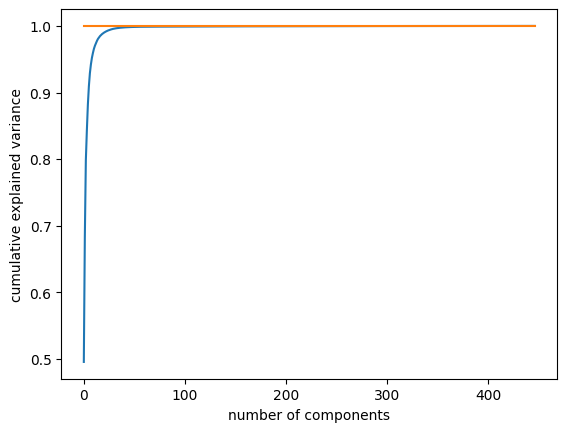

first_ap_dv 10


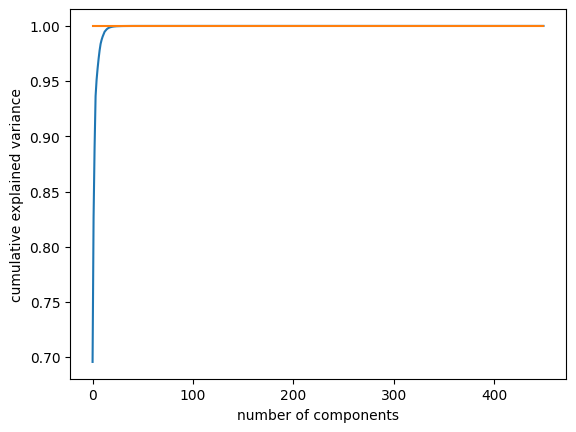

first_ap_v 6


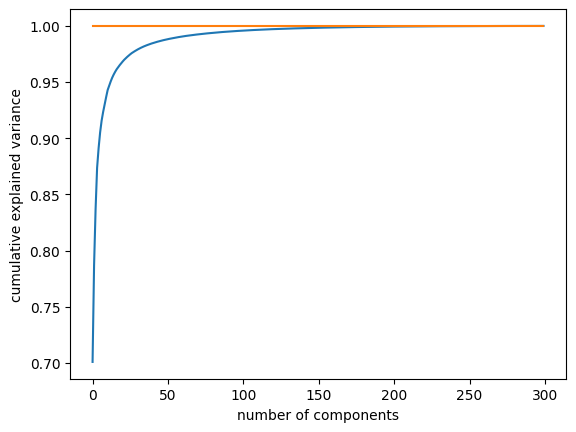

inst_freq 10


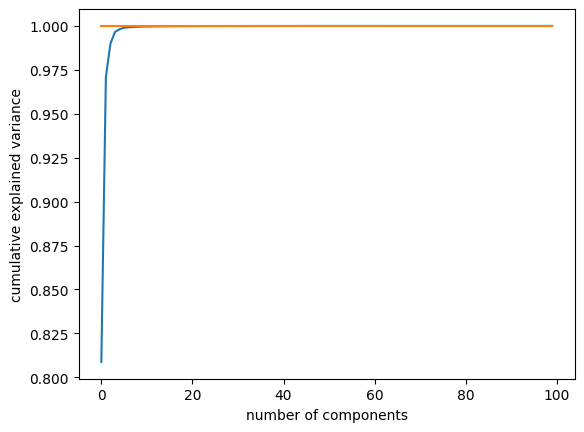

isi_shape 1


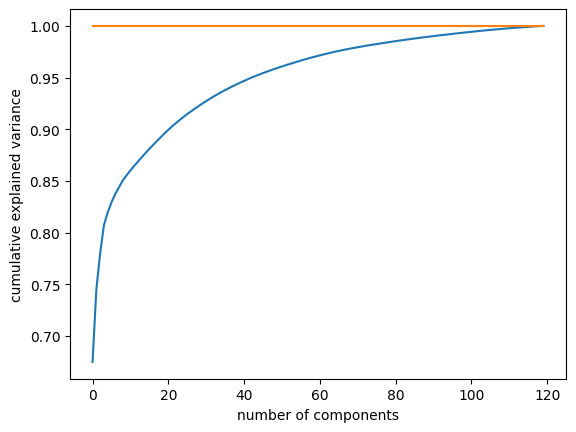

psth 10


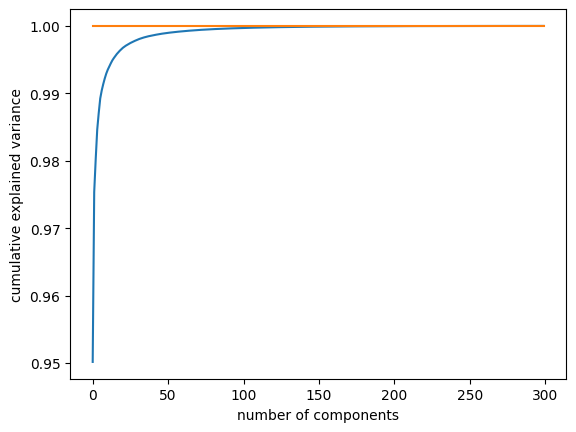

spiking_fast_trough_v 1


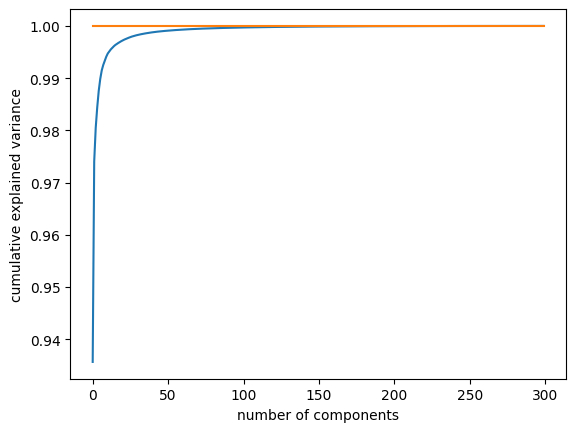

spiking_peak_v 1


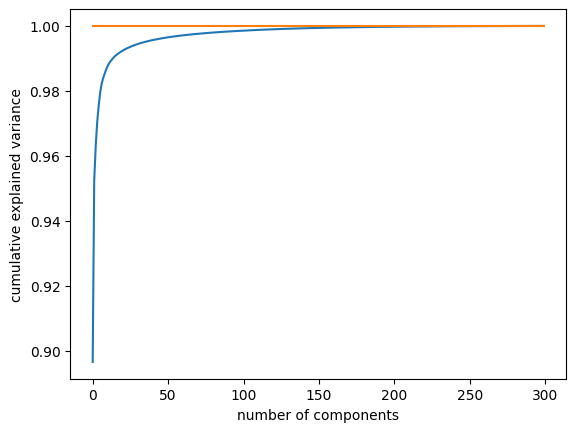

spiking_threshold_v 3


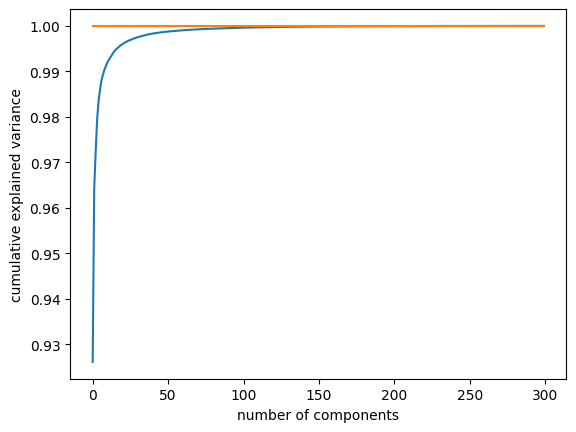

spiking_upstroke_downstroke_ratio 2


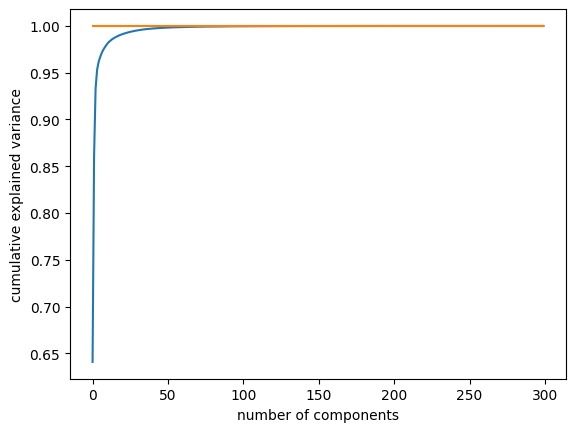

spiking_width 6


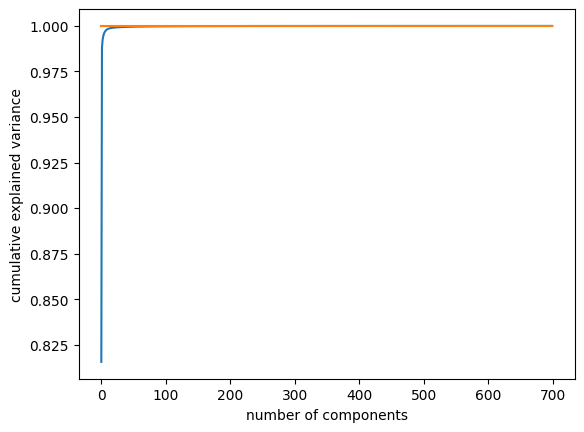

step_subthresh 1


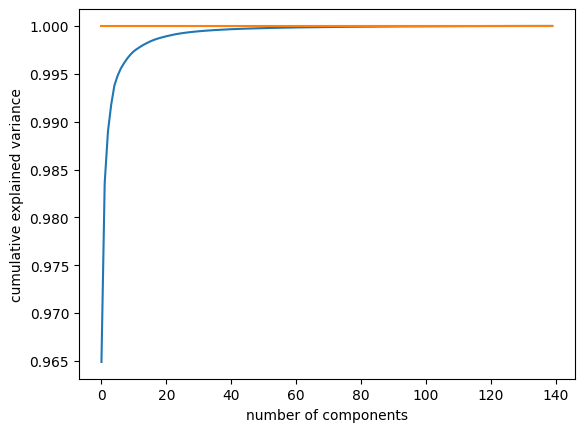

subthresh_depol_norm 1


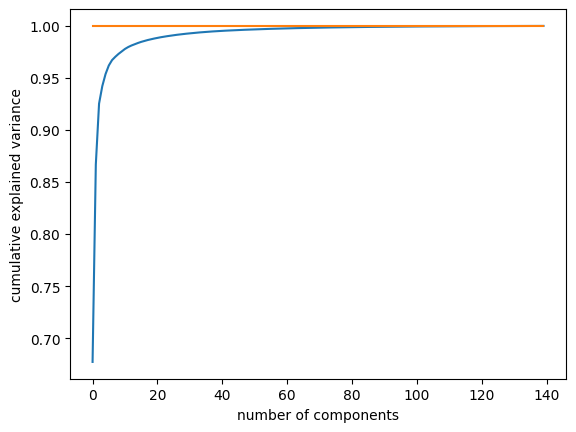

subthresh_norm 7
first_ap_dv (7818, 10)
first_ap_v (7818, 6)
inst_freq (7818, 10)
isi_shape (7818, 1)
psth (7818, 10)
spiking_fast_trough_v (7818, 1)
spiking_peak_v (7818, 1)
spiking_threshold_v (7818, 3)
spiking_upstroke_downstroke_ratio (7818, 2)
spiking_width (7818, 6)
step_subthresh (7818, 1)
subthresh_depol_norm (7163, 1)
subthresh_norm (7818, 7)


In [9]:
print("...................................................")
print("PCA analysis")
# Apply PCA and keep the n components as computed below
number_of_components = {}
for k in hf.keys():
    if k not in ["ids"]:
        n_comp_at_thr = proc_utils.get_PCA_explained_variance_ratio_at_thr(
            nparray=time_series[k], threshold=pca_th)
        #If number of components are zero, then use 1
        if n_comp_at_thr == 0:
            number_of_components[k] = 1
        else:
            if n_comp_at_thr > 10:
                number_of_components[k] = 10
            else:
                number_of_components[k] = n_comp_at_thr
        print(k, number_of_components[k])

PC = {}
for k in hf.keys():
    if k != "ids":
        pca = PCA(number_of_components[k])
        PC[k] = pca.fit_transform(time_series[k])
        print(k, PC[k].shape)

In [10]:
print("...................................................")
print("Scaling PCA features")
#Scaling PC features
Scaled_PCs = {}
total_var = {}

for k in PC.keys():
    total_var[k] = np.sqrt(np.sum(pd.DataFrame(PC[k]).var(axis=0)))
    Scaled_PCs[k] = PC[k] / total_var[k]
    if (proc_utils.check_for_nan(Scaled_PCs[k])):
        Scaled_PCs[k], _ = proc_utils.drop_nan_rows_or_cols(Scaled_PCs[k], axis=1)

...................................................
Scaling PCA features


In [11]:
print("...................................................")
print("Removing outliers whithin 6 std from scaled PCs")
#attaching specimen ids and removing outliers
for k in PC.keys():
    print(Scaled_PCs[k].shape)
    Scaled_PCs[k] = pd.DataFrame(Scaled_PCs[k])
    scaling_thr = np.abs(np.max(Scaled_PCs[k].std(axis=0, skipna=True, numeric_only=True)) * 6)
    Scaled_PCs[k] = Scaled_PCs[k][(Scaled_PCs[k] < scaling_thr) & (Scaled_PCs[k] > -1 * scaling_thr)]
    Scaled_PCs[k].columns = [k + "_" + str(i) for i in range(Scaled_PCs[k].shape[1])]
    if k not in dropped_cells.keys():
        Scaled_PCs[k]["specimen_id"] = h5_ids
    else:
        Scaled_PCs[k]["specimen_id"] = np.delete(h5_ids, obj=dropped_cells[k])

    Scaled_PCs[k]['specimen_id'] = [str(i) for i in Scaled_PCs[k]['specimen_id']]

...................................................
Removing outliers whithin 6 std from scaled PCs
(7818, 10)
(7818, 6)
(7818, 10)
(7818, 1)
(7818, 10)
(7818, 1)
(7818, 1)
(7818, 3)
(7818, 2)
(7818, 6)
(7818, 1)
(7163, 1)
(7818, 7)


Zero-mean the scaled PCs
...................................................


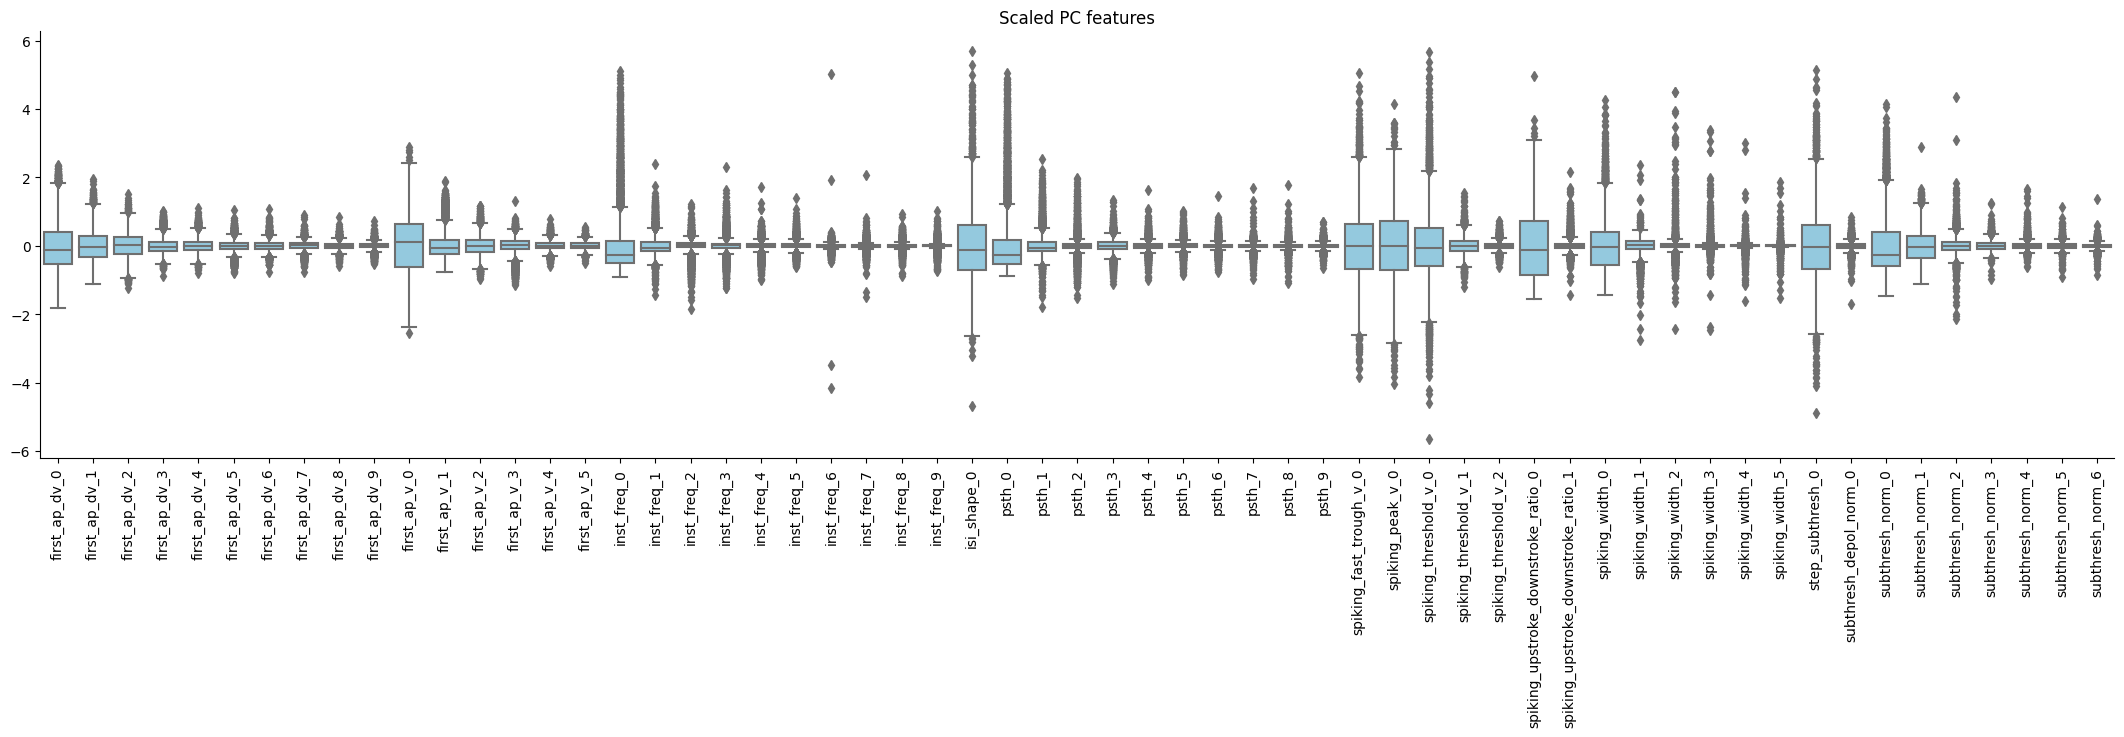

In [12]:
#Merge all scaled PC features into one df
data_frames = []
for k in Scaled_PCs.keys():
    data_frames.append(Scaled_PCs[k])

Scaled_PCs = reduce(lambda left, right: pd.merge(left, right, on=['specimen_id'], how='outer'), data_frames)
print("Zero-mean the scaled PCs")
print("...................................................")
subset_Scaled_PCs = Scaled_PCs[[c for c in Scaled_PCs.columns if c != "specimen_id"]]
subset_Scaled_PCs = (subset_Scaled_PCs - subset_Scaled_PCs.mean(axis=0)) 
subset_Scaled_PCs['specimen_id'] = Scaled_PCs['specimen_id']
Scaled_PCs = subset_Scaled_PCs

df = Scaled_PCs.melt(value_vars=Scaled_PCs[[c for c in Scaled_PCs.columns if c != "specimen_id"]])
sns.catplot(x="variable", y="value", kind='box', data=df, palette=sns.color_palette(["skyblue"]), aspect=4.4)
ax = plt.gca()
ax.set(**{'title': 'Scaled PC features', 'xlabel': '', 'ylabel': ''})
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [13]:
# Loading ipfx features 
print("Scaled PCs size:", Scaled_PCs.shape)
print("...................................................")
print("Loading ipfx features")
ipfx = pd.read_csv(dir_pth['ipfx_features'])

keep_ipfx_features_bioarxiv = ['ap_1_threshold_v_short_square', 'ap_1_peak_v_short_square',
        'ap_1_upstroke_short_square', 'ap_1_downstroke_short_square',
        'ap_1_upstroke_downstroke_ratio_short_square',
        'ap_1_width_short_square', 'ap_1_fast_trough_v_short_square',
        'short_square_current', 'input_resistance', 'tau', 'v_baseline',
        'sag_nearest_minus_100', 'sag_measured_at', 'rheobase_i',
        'ap_1_threshold_v_0_long_square', 'ap_1_peak_v_0_long_square',
        'ap_1_upstroke_0_long_square', 'ap_1_downstroke_0_long_square',
        'ap_1_upstroke_downstroke_ratio_0_long_square',
        'ap_1_width_0_long_square', 'ap_1_fast_trough_v_0_long_square',
        'avg_rate_0_long_square', 'latency_0_long_square',
        'stimulus_amplitude_0_long_square', "specimen_id"]

ipfx = ipfx[keep_ipfx_features_bioarxiv]

Scaled PCs size: (7818, 60)
...................................................
Loading ipfx features


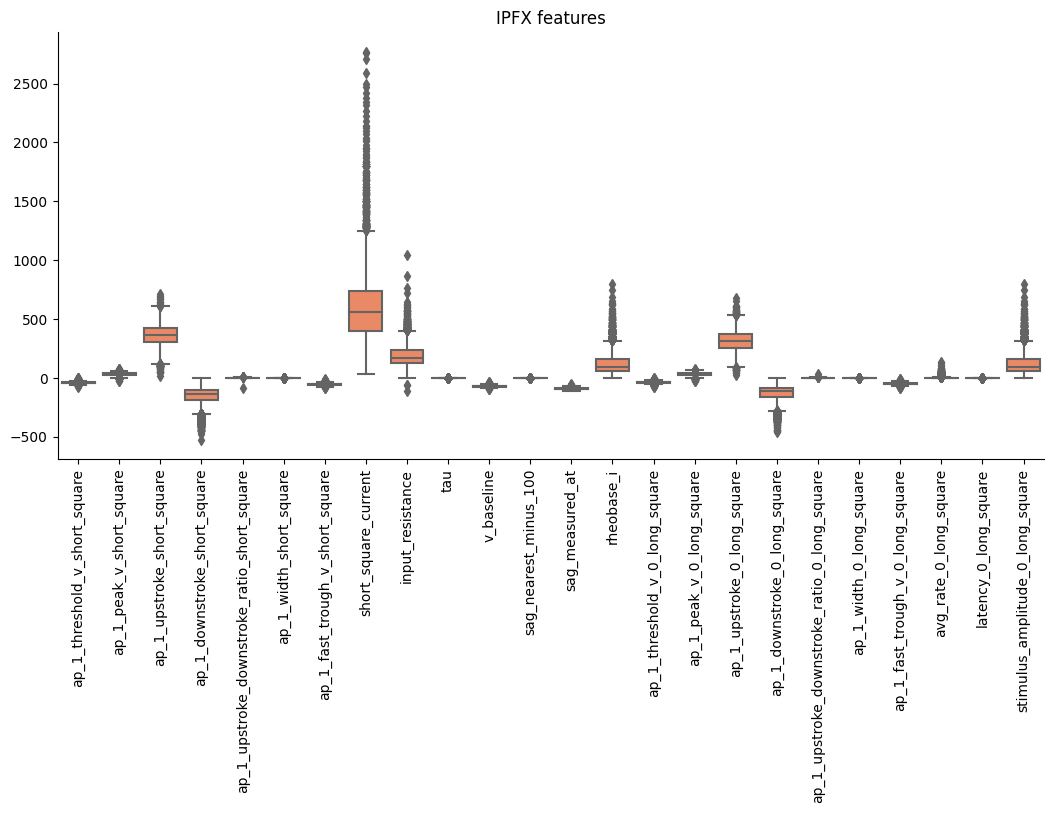

In [14]:
df = ipfx.melt(value_vars=ipfx[[c for c in ipfx.columns if c != "specimen_id"]])
sns.catplot(x="variable", y="value",kind='box', data=df, palette=sns.color_palette(["coral"]),aspect=2.4)
ax = plt.gca()
ax.set(**{'title':'IPFX features','xlabel':'','ylabel':''})
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

...................................................
Zscoring ipfx features
Removing extreme ipfx values (within 6 std)


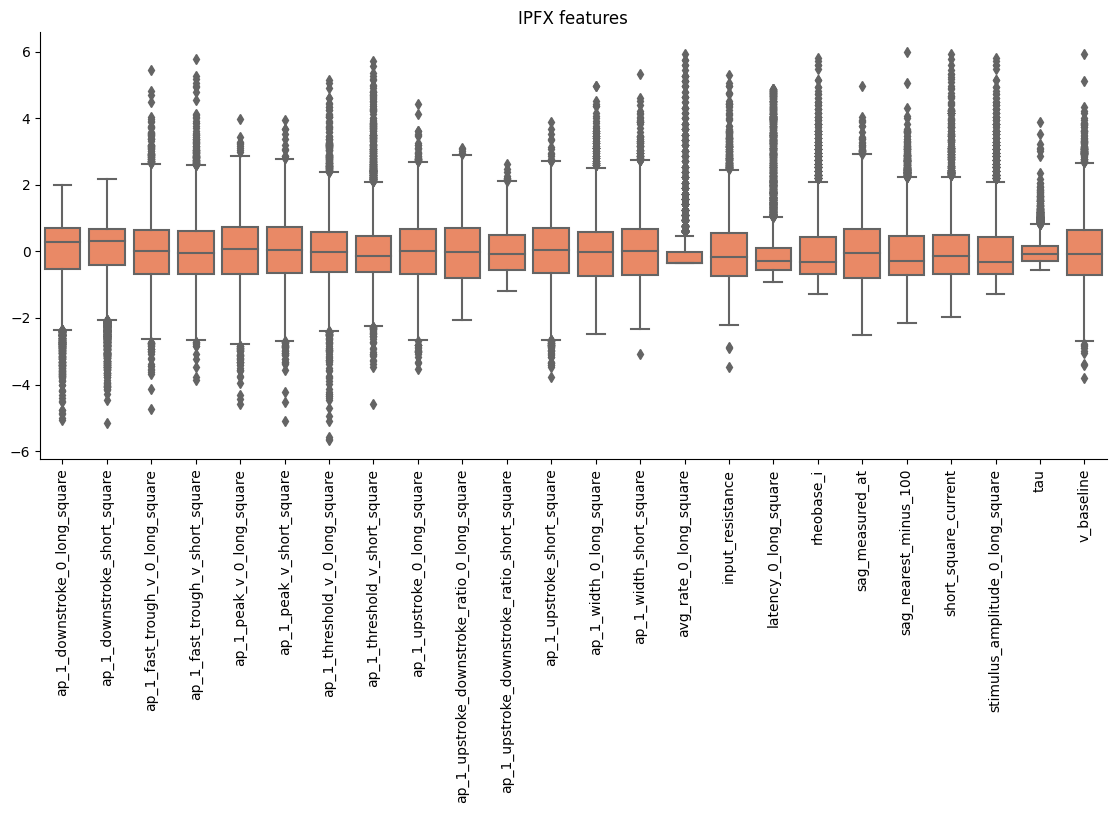

In [15]:
print("...................................................")
print("Zscoring ipfx features")
subset_ipfx = ipfx[[c for c in ipfx.columns if c != "specimen_id"]]
ipfx_norm = (subset_ipfx - subset_ipfx.mean(axis=0)) / subset_ipfx.std(axis=0)

print("Removing extreme ipfx values (within 6 std)")
scaling_thr = ipfx_norm.std(axis=0, skipna=True, numeric_only=True) * 6
ipfx_norm = ipfx_norm.reset_index()
df1 = pd.melt(ipfx_norm, id_vars=['index'], value_vars=[c for c in ipfx_norm if c != "index"])
df2 = pd.DataFrame(scaling_thr).reset_index().rename(columns={"index": 'variable', 0:"thr_std"})
df3 = df1.merge(df2, on="variable")
df3['new_value'] = np.where((df3['value'] < df3['thr_std']) & (df3['value'] > -1 * df3['thr_std'])
                        , df3['value'], np.nan)
ipfx_norm = df3.pivot(index='index', columns="variable", values="new_value")
ipfx_norm['specimen_id'] = ipfx['specimen_id'].astype(str)

df = ipfx_norm.melt(value_vars=ipfx_norm[[c for c in ipfx_norm.columns if c != "specimen_id"]])
sns.catplot(x="variable", y="value", kind='box', data=df, palette=sns.color_palette(["coral"]),aspect=2.4)
ax = plt.gca()
ax.set(**{'title': 'IPFX features', 'xlabel': '', 'ylabel':''})
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [16]:
print("ipfx features size:", ipfx_norm.shape)

print("...................................................")
print("Merging all E features together")

data_frames = [Scaled_PCs, ipfx_norm]
df_merged = reduce(lambda left, right: pd.merge(left, right, on=['specimen_id'], how='outer'), data_frames)
##################### From here
print("...................................................")
print("Removing some of the features than more than %50 of data dont have that feature")
drop_feature_thr = int(df_merged.shape[0]*0.05)
temp = df_merged.isnull().sum(axis=0).reset_index()
feature_to_drop = temp[temp[0]>drop_feature_thr]['index'].astype(str).to_list()
df_merged = df_merged[[col for col in df_merged.columns.to_list() if col not in feature_to_drop]]
df_merged = df_merged[~df_merged.isnull().any(axis=1)]
###################### keep until here if you want to remove bad features and bad cells
df_merged['specimen_id'] = df_merged['specimen_id'].astype(str)
df_merged = df_merged.merge(pd.DataFrame(specimen_ids, columns=["specimen_id"]), on="specimen_id", how='right')

ipfx features size: (7841, 25)
...................................................
Merging all E features together
...................................................
Removing some of the features than more than %50 of data dont have that feature


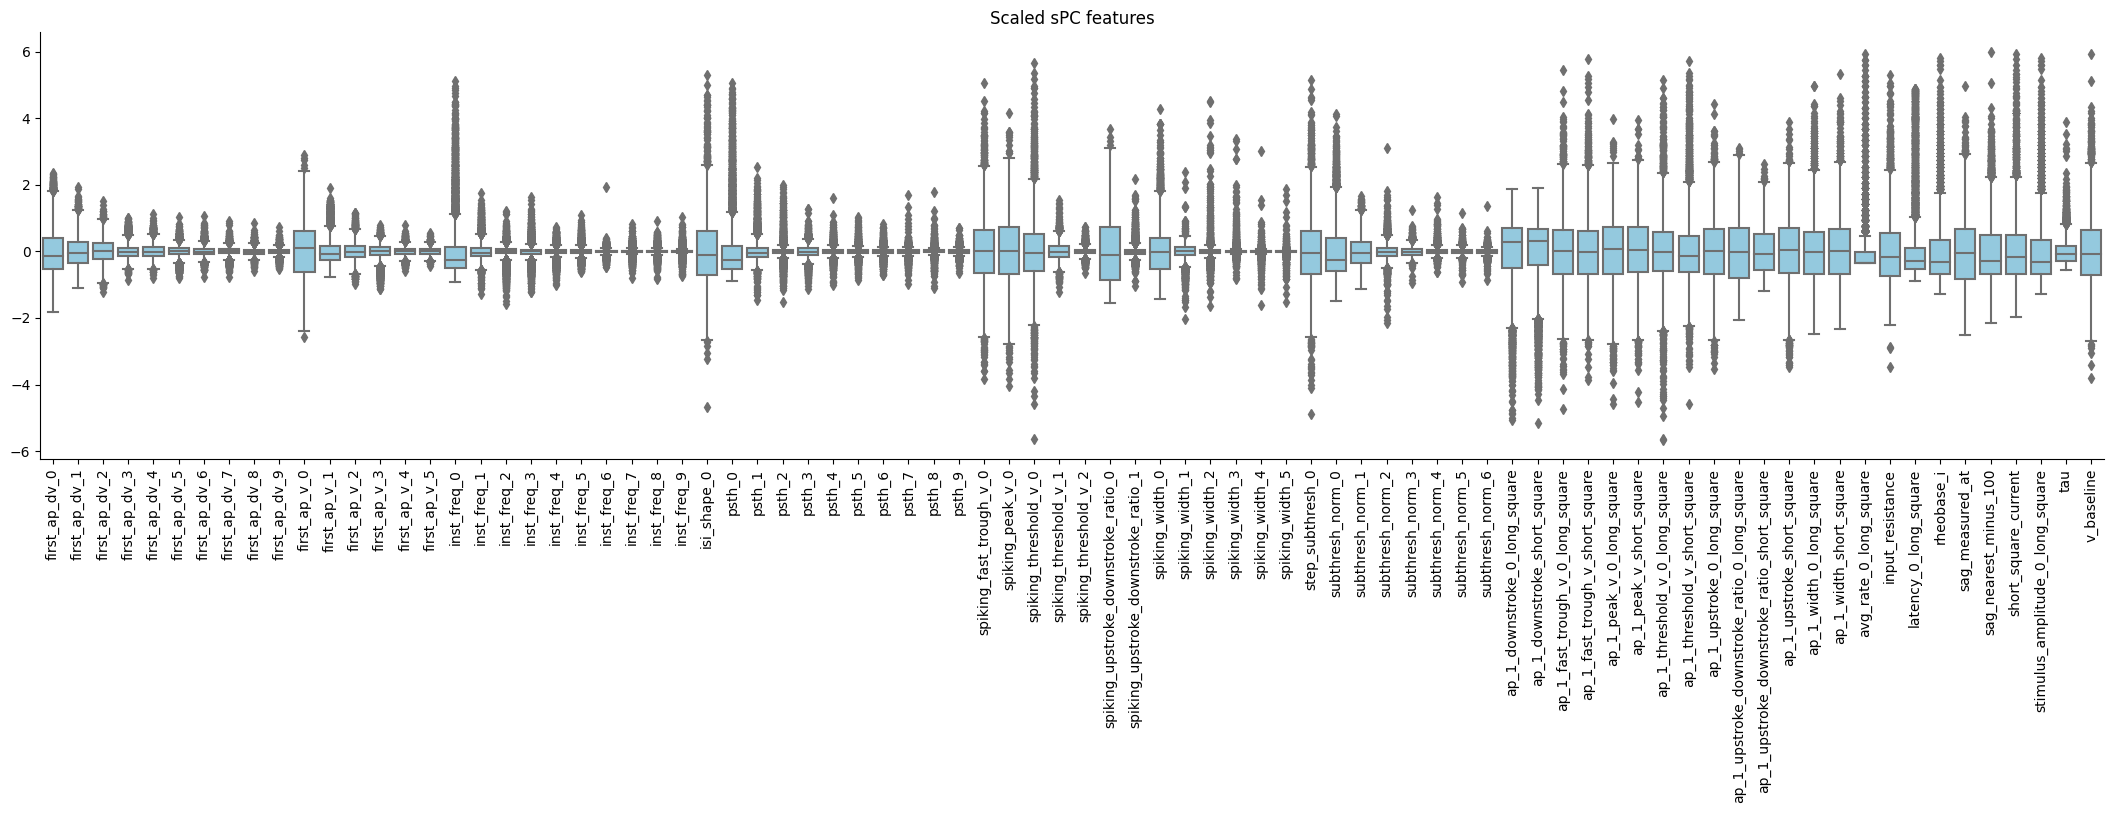

Size of Merged E features: (16703, 83)
Done


In [17]:
# Make sure the order is the same as th
df_merged = df_merged.set_index('specimen_id')
df_merged = df_merged.loc[specimen_ids].reset_index()
df_merged.to_csv(dir_pth['e_output'], index=False)

f = df_merged
df = f.melt(value_vars=f[[c for c in f.columns if c != "specimen_id"]])
sns.catplot(x="variable", y="value", kind='box', data=df, palette=sns.color_palette(["skyblue"]), aspect=4.4)
ax = plt.gca()
ax.set(**{'title': 'Scaled sPC features', 'xlabel': '', 'ylabel': ''})
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

print("Size of Merged E features:", df_merged.shape)
print("Done")

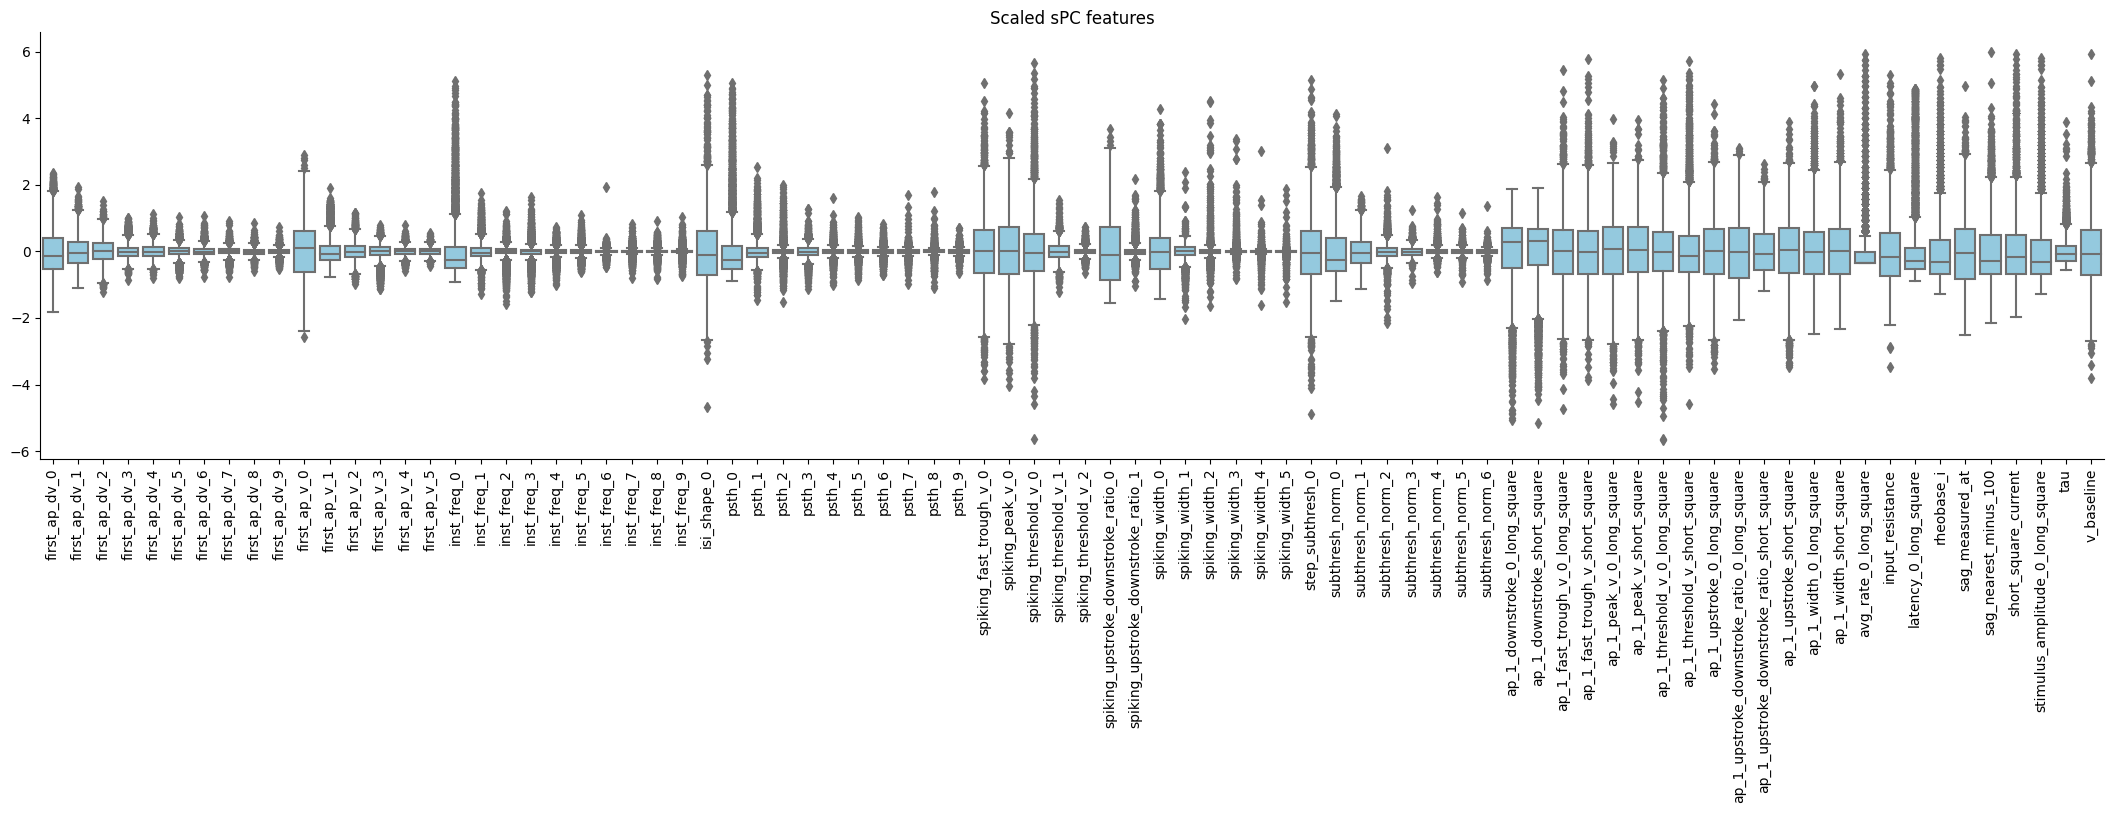

Size of Merged E features: (16703, 83)
Done


In [18]:
# Make sure the order is the same as th
df_merged = df_merged.set_index('specimen_id')
df_merged = df_merged.loc[specimen_ids].reset_index()
df_merged.to_csv(dir_pth['e_output'], index=False)

f = df_merged
df = f.melt(value_vars=f[[c for c in f.columns if c != "specimen_id"]])
sns.catplot(x="variable", y="value", kind='box', data=df, palette=sns.color_palette(["skyblue"]), aspect=4.4)
ax = plt.gca()
ax.set(**{'title': 'Scaled sPC features', 'xlabel': '', 'ylabel': ''})
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

print("Size of Merged E features:", df_merged.shape)
print("Done")